In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
  dftest = adfuller(df, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

  print("----------")

  return dftest[1]

In [5]:
def correct(df,column,factor):
    clone_column = df[column]
    
    df["diff"] = clone_column.diff()
    df["diff_abs"] = df["diff"].apply(np.absolute)
    diff_mean = df["diff_abs"].dropna().mean()
    
    threshold_factor = factor 
    anomalies = df.loc[ ~(df["diff"].isnull()) & (df["diff_abs"].dropna() > threshold_factor * diff_mean)]
    
    df["new"] = clone_column

    for i in range(len(anomalies)):
        df_od_curr = df.loc[ df["date"] == anomalies.iloc[i]["date"] ]
        df_od_prev = df.loc[df_od_curr.index -1]

        od_curr_index = df_od_curr.index[0]

        od_curr = df_od_curr.iloc[0][column]
        od_prev = df_od_prev.iloc[0][column]
        shifter = round(od_curr - od_prev , 2)

        for j in range(0,od_curr_index):
            df.loc[j,"new"] += [shifter]

    return df["new"]

In [6]:
def limit_range(df, column, min, max):
    df.loc[df[df[column] < min].index,column] = min
    df.loc[df[df[column] > max].index,column] = max

    return df[column]

In [7]:
def correct_with_range(df,column,factor,min,max):
    clone_column = df[column]
    
    df["diff"] = clone_column.diff()
    df["diff_abs"] = df["diff"].apply(np.absolute)
    diff_mean = df["diff_abs"].dropna().mean()
    
    threshold_factor = factor 
    anomalies = df.loc[ ~(df["diff"].isnull()) & (df["diff_abs"].dropna() > threshold_factor * diff_mean)]
    
    df["new"] = clone_column

    for i in range(len(anomalies)):
        df_od_curr = df.loc[ df["date"] == anomalies.iloc[i]["date"] ]
        df_od_prev = df.loc[df_od_curr.index -1]

        od_curr_index = df_od_curr.index[0]

        od_curr = df_od_curr.iloc[0][column]
        od_prev = df_od_prev.iloc[0][column]
        shifter = round(od_curr - od_prev , 2)

        for j in range(0,od_curr_index):
            df.loc[j,"new"] += [shifter]

            if df.loc[j,"new"] > [max]:
                df.loc[j,"new"] = [max]
            elif df.loc[j,"new"] < [min]:
                df.loc[j,"new"] = [min]
        
    return df["new"]

In [8]:
def limit_range(df,column,min,max):
    return

In [9]:
df_1 = pd.read_csv("WatKhlongKhuan.csv")
# df_1

In [10]:
df_2 = pd.read_csv("WatKhlongKhuan (3).csv")
# df_2

In [11]:
df_1.rename(columns={"Date":"date",
    "Temperature":"temperature",
    "ph":"pH",
    "EC":"ec"},
    inplace=True)

# df_1

In [12]:
df_2.rename(columns = {
    "ph":"pH"
    },
    inplace=True)

In [13]:
df_1["date"] = pd.to_datetime(df_1["date"], format = "%m/%d/%Y %H:%M")

In [14]:
df_2["date"] = pd.to_datetime(df_2["date"], format = "%Y-%m-%d %H:%M")

In [15]:
df = pd.concat([df_1,df_2])
# df

In [16]:
df.drop(["place","salinity"], axis=1, inplace=True)

In [17]:
df.drop_duplicates(subset=['date'], keep='first', inplace=True)

In [18]:
df.sort_values("date",inplace=True)
df.reset_index(drop=True,inplace=True)

In [19]:
df = df.resample("1H",on="date").mean().interpolate(method="time")
df.reset_index(inplace=True)

In [20]:
df.loc[df[df["pH"] < 1].index,"pH"] = 1
df.loc[df[df["pH"] > 14].index,"pH"] = 14

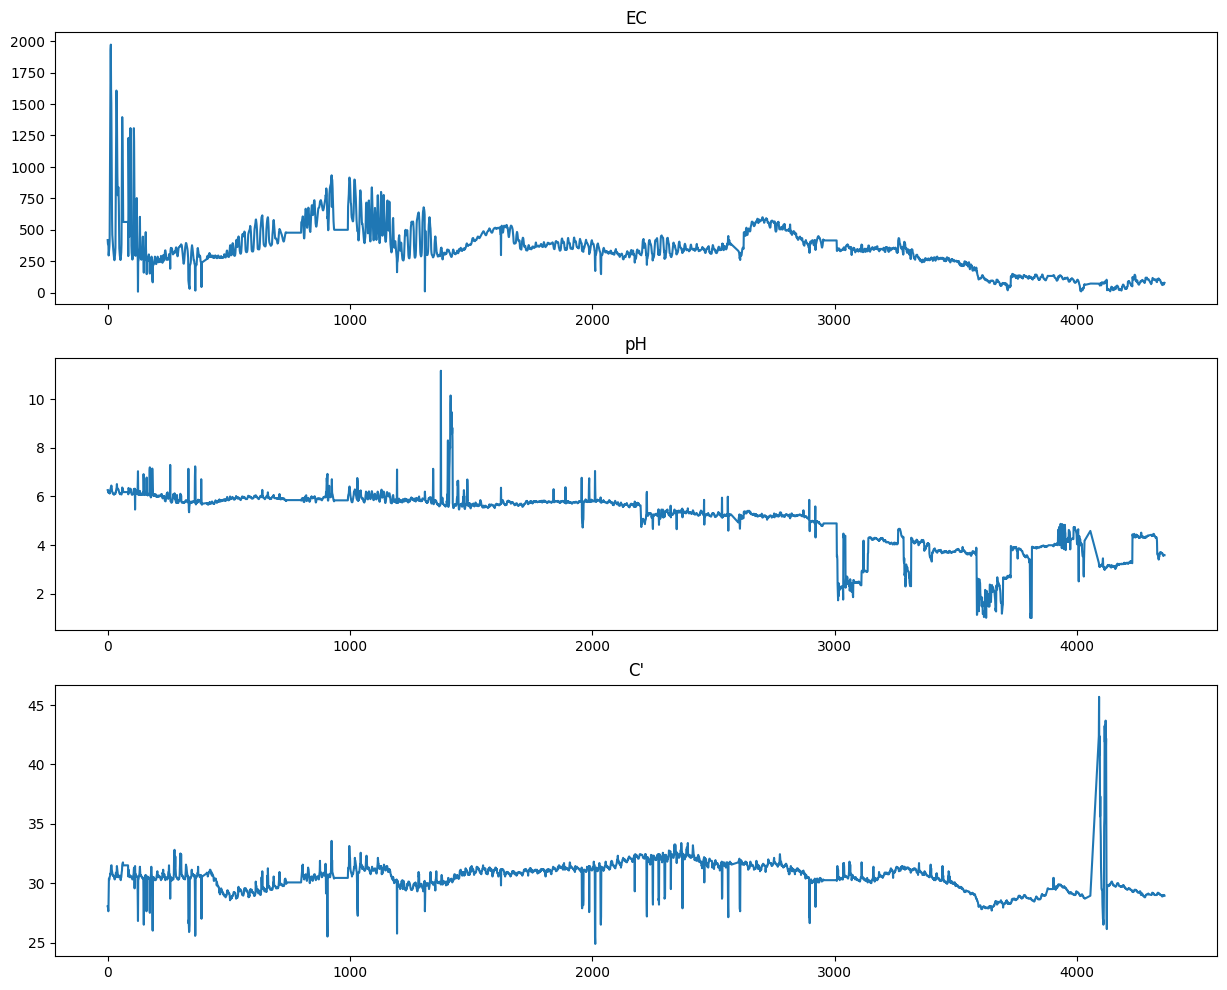

In [21]:
plt.figure(figsize = (15, 12))

plt.subplot(3,1,1)
plt.plot(df["ec"])
plt.title('EC')

plt.subplot(3,1,2)
plt.plot(df["pH"])
plt.title('pH')

plt.subplot(3,1,3)
plt.plot(df["temperature"])
plt.title('C\'')

plt.show()

In [22]:
df_train = df.copy()
# df_train = df.drop(["pH","temperature"],axis=1)
# df_train = df.drop(["pH","ec"],axis=1)
# df_train = df.drop(["ec","temperature"],axis=1)

df_train.reset_index(inplace=True)
df_train

,index,date,temperature,pH,ec
0,0,2022-03-15 00:00:00,28.06,6.26,419.30
1,1,2022-03-15 01:00:00,28.06,6.23,390.10
2,2,2022-03-15 02:00:00,27.69,6.20,380.10
3,3,2022-03-15 03:00:00,27.63,6.24,376.30
4,4,2022-03-15 04:00:00,29.25,6.14,296.70
...,...,...,...,...,...
4357,4357,2022-09-12 13:00:00,29.00,3.57,72.90
4358,4358,2022-09-12 14:00:00,29.00,3.60,66.03
4359,4359,2022-09-12 15:00:00,29.00,3.58,70.98
4360,4360,2022-09-12 16:00:00,29.00,3.58,77.63


In [23]:
# df_train = df_train.resample("1H",on="date").mean().interpolate(method="time")
# df_train.reset_index(inplace=True)

In [7]:
df_train["ec_diff"] = df_train["ec"].diff()

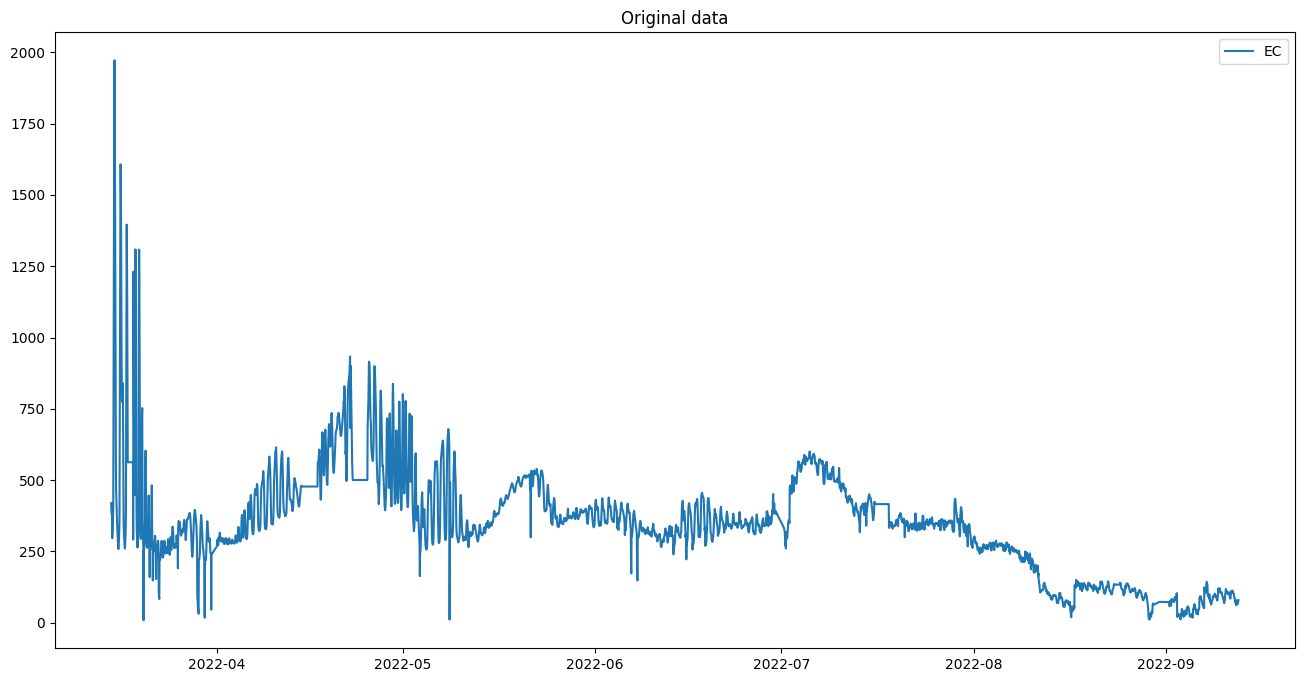

In [77]:
plt.figure(figsize=(16,8))
plt.title("Original data")
plt.plot(df_train["date"], df_train["ec"], label = "EC")
plt.legend()

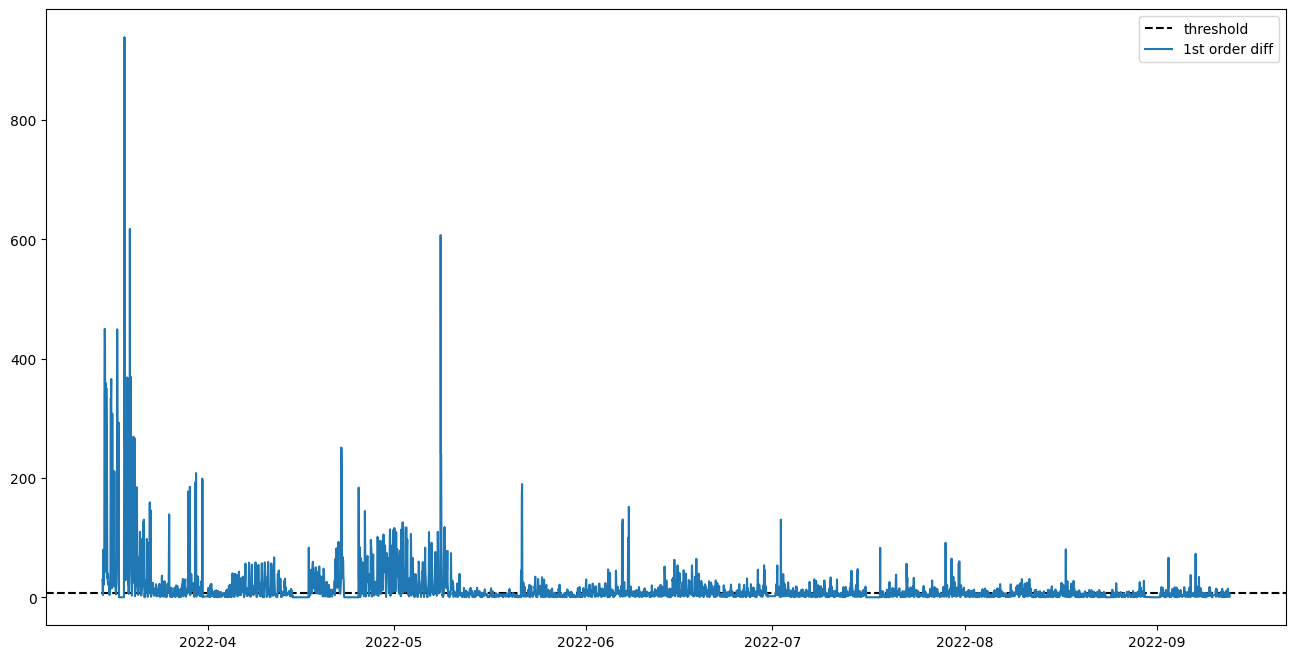

In [15]:
plt.figure(figsize=(16,8))
plt.axhline(y = df_train["ec_diff"].abs().mean() * .5, color = "k", linestyle = "--", label="threshold")
plt.plot(df_train["date"], df_train["ec_diff"].abs(), label="1st order diff")
plt.legend()

In [27]:
# df_train["ec_diff_abs"] = df_train["ec_diff"].apply(np.absolute)

In [28]:
# ec_diff_mean = df_train["ec_diff_abs"].dropna().mean()

In [29]:
# anomaly_factor = .5

In [30]:
# anomalies = df_train.loc[ ~(df_train["ec_diff"].isnull()) & (df_train["ec_diff_abs"].dropna() > anomaly_factor * ec_diff_mean)]

In [31]:
# df_train["ec_new"] = df_train["ec"]

In [ ]:
df_train["ec_new_4"] = correct(df_train,"ec",4)
df_train["ec_new_3"] = correct(df_train,"ec",3)
df_train["ec_new_2"] = correct(df_train,"ec",2)
df_train["ec_new_1"] = correct(df_train,"ec",1)
df_train["ec_new_.5"] = correct(df_train,"ec",.5)

In [4]:
df_train = pd.read_csv("corrected_data.csv", parse_dates=["date"])

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4362 entries, 0 to 4361
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        4362 non-null   object        
 1   date         4362 non-null   datetime64[ns]
 2   temperature  4362 non-null   float64       
 3   pH           4362 non-null   float64       
 4   ec           4362 non-null   float64       
 5   ec_new_4     4362 non-null   float64       
 6   ec_new_3     4362 non-null   float64       
 7   ec_new_2     4362 non-null   float64       
 8   ec_new_1     4362 non-null   float64       
 9   ec_new_.5    4362 non-null   float64       
 10  pH_new_4     4362 non-null   float64       
 11  pH_new_3     4362 non-null   float64       
 12  pH_new_2     4362 non-null   float64       
 13  pH_new_1     4362 non-null   float64       
 14  pH_new_.5    4362 non-null   float64       
 15  temp_new_.5  4362 non-null   float64       
 16  temp_n

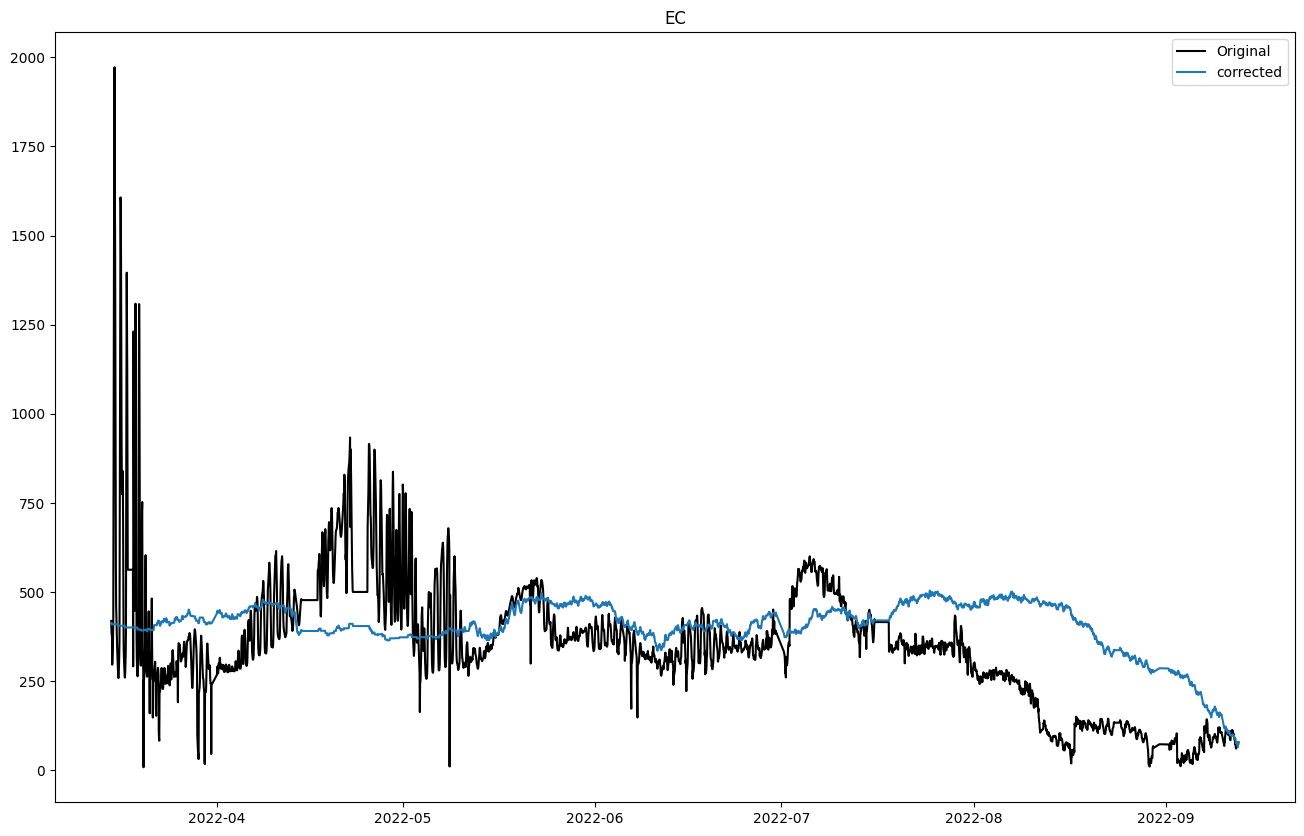

In [16]:
plt.figure(figsize=(16,10))
plt.title("EC")
plt.plot(df_train["date"], df_train["ec"], label="Original", color = "k")
# plt.plot(df_train["date"], df_train["ec_new_4"], label="corrected_4", color="r")
# plt.plot(df_train["date"], df_train["ec_new_3"], label="corrected_3", color = "g")
# plt.plot(df_train["date"], df_train["ec_new_2"], label="corrected_2", color="b")
# plt.plot(df_train["date"], df_train["ec_new_1"], label="corrected_1")
plt.plot(df_train["date"], df_train["ec_new_.5"], label="corrected")
plt.legend()

In [ ]:
df_train["pH_new_4"] = correct_with_range(df_train,"pH",4,1,14)
df_train["pH_new_3"] = correct_with_range(df_train,"pH",3,1,14)
df_train["pH_new_2"] = correct_with_range(df_train,"pH",2,1,14)
df_train["pH_new_1"] = correct_with_range(df_train,"pH",1,1,14)
df_train["pH_new_.5"] = correct_with_range(df_train,"pH",.5,1,14)

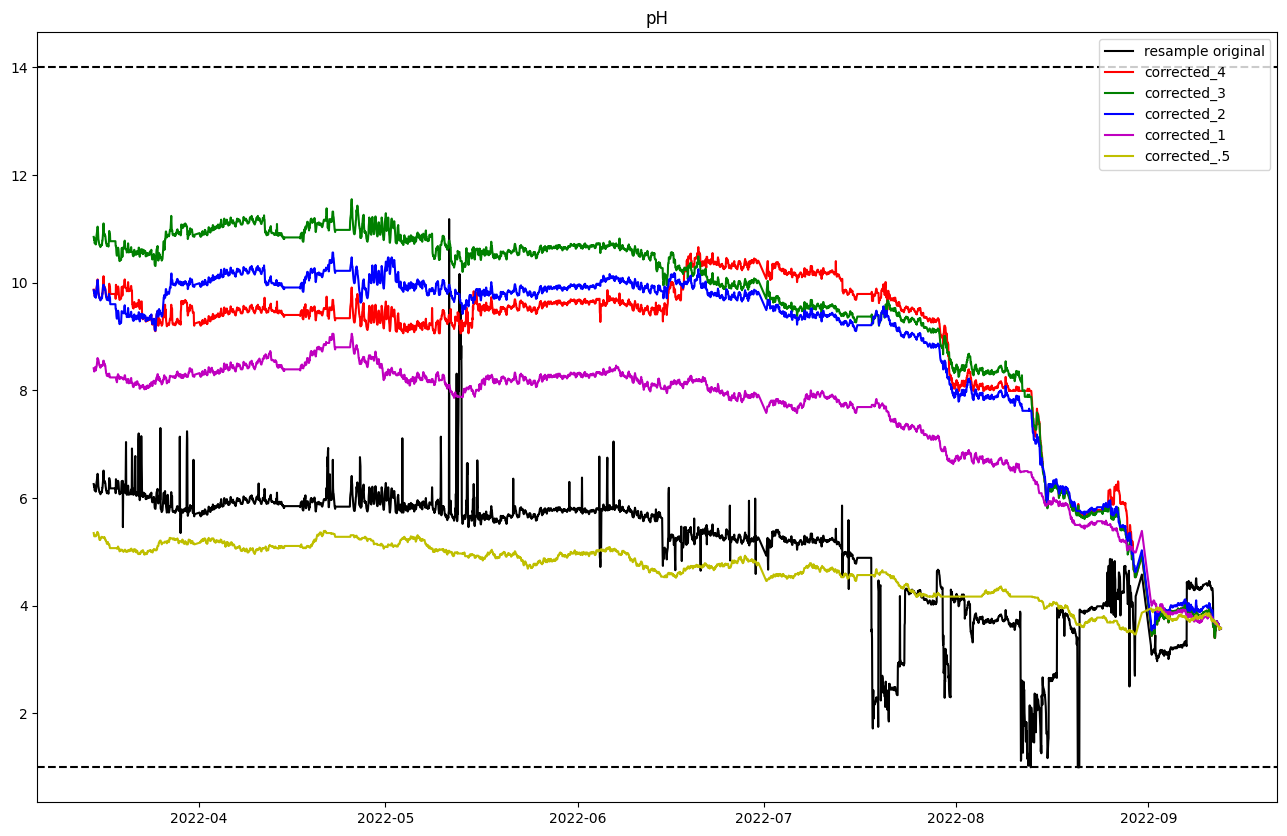

In [64]:
plt.figure(figsize=(16,10))
plt.title("pH")
plt.axhline(y = 14, color = "k", linestyle = "--")
plt.axhline(y = 1, color = "k", linestyle = "--")
plt.plot(df_train["date"], df_train["pH"], label="resample original", color = "k")
plt.plot(df_train["date"], df_train["pH_new_4"], label="corrected_4", color = "r")
plt.plot(df_train["date"], df_train["pH_new_3"], label="corrected_3", color = "g")
plt.plot(df_train["date"], df_train["pH_new_2"], label="corrected_2", color = "b")
plt.plot(df_train["date"], df_train["pH_new_1"], label="corrected_1", color ="m")
plt.plot(df_train["date"], df_train["pH_new_.5"], label="corrected_.5", color ="y")
plt.legend()

In [ ]:
df_train["temp_new_4"] = correct_with_range(df_train,"temperature",4,0,100)
df_train["temp_new_3"] = correct_with_range(df_train,"temperature",3,0,100)
df_train["temp_new_2"] = correct_with_range(df_train,"temperature",2,0,100)
df_train["temp_new_1"] = correct_with_range(df_train,"temperature",1,0,100)
df_train["temp_new_.5"] = correct_with_range(df_train,"temperature",.5,0,100)

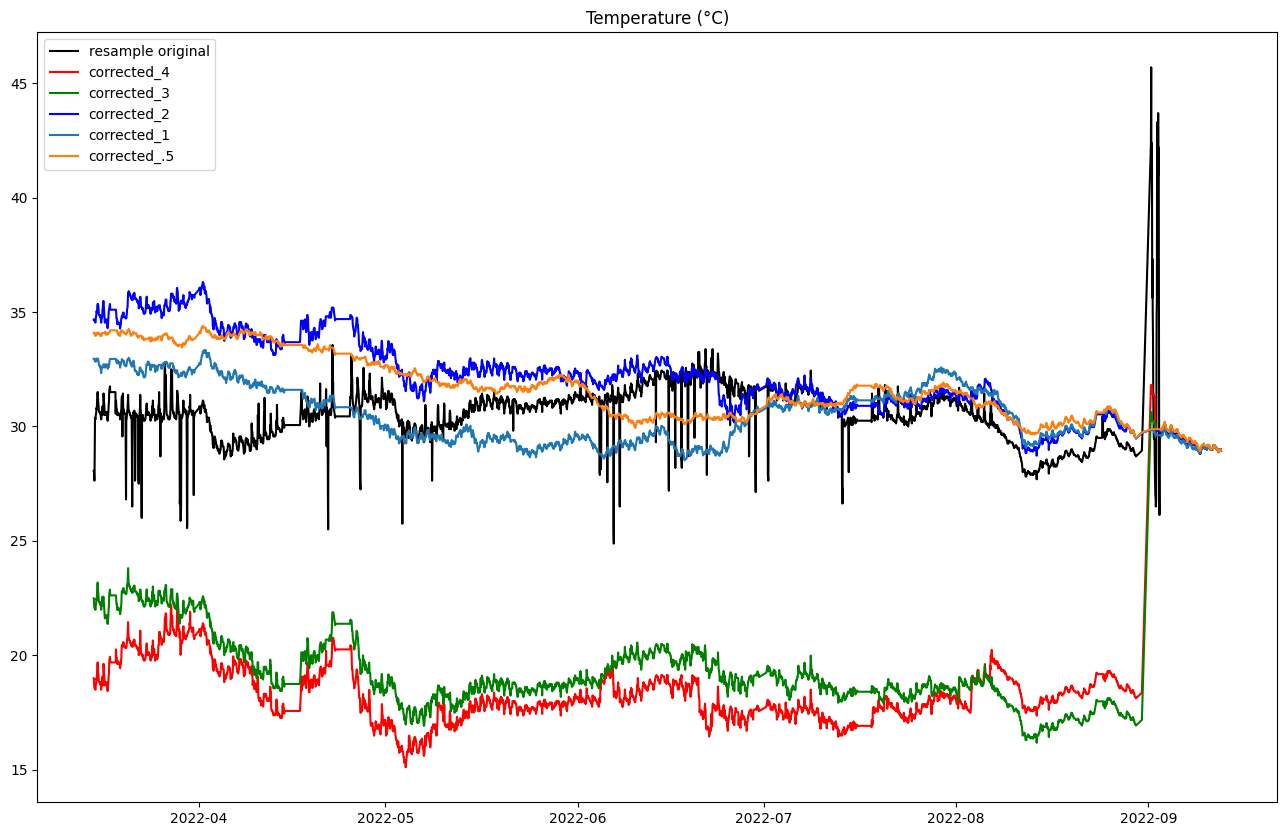

In [63]:
plt.figure(figsize=(16,10))
plt.title("Temperature (°C)")
# plt.axhline(y = 50, color = "k", linestyle = "--")
# plt.axhline(y = 20, color = "k", linestyle = "--")
plt.plot(df_train["date"], df_train["temperature"], label="resample original", color = "k")
plt.plot(df_train["date"], df_train["temp_new_4"], label="corrected_4", color = "r")
plt.plot(df_train["date"], df_train["temp_new_3"], label="corrected_3", color = "g")
plt.plot(df_train["date"], df_train["temp_new_2"], label="corrected_2", color = "b")
plt.plot(df_train["date"], df_train["temp_new_1"], label="corrected_1")
plt.plot(df_train["date"], df_train["temp_new_.5"], label="corrected_.5")
plt.legend()

In [270]:
df_export = df_train.drop(["diff","diff_abs","new"], axis=1)
# df_export

,index,date,temperature,pH,ec,ec_new_4,ec_new_3,ec_new_2,ec_new_1,ec_new_.5,pH_new_4,pH_new_3,pH_new_2,pH_new_1,pH_new_.5,temp_new_.5,temp_new_4,temp_new_3,temp_new_2,temp_new_1
0,0,2022-03-15 00:00:00,28.06,6.26,419.30,1327.50,1394.40,814.02,658.19,413.39,9.87,10.85,9.86,8.41,5.35,34.09,19.00,22.49,34.67,32.96
1,1,2022-03-15 01:00:00,28.06,6.23,390.10,1298.30,1365.20,784.82,658.19,413.39,9.84,10.82,9.83,8.38,5.32,34.09,19.00,22.49,34.67,32.96
2,2,2022-03-15 02:00:00,27.69,6.20,380.10,1288.30,1355.20,774.82,648.19,413.39,9.81,10.79,9.80,8.35,5.29,34.09,18.63,22.12,34.67,32.96
3,3,2022-03-15 03:00:00,27.63,6.24,376.30,1284.50,1351.40,771.02,644.39,409.59,9.85,10.83,9.84,8.39,5.29,34.03,18.57,22.06,34.61,32.90
4,4,2022-03-15 04:00:00,29.25,6.14,296.70,1284.50,1351.40,771.02,644.39,409.59,9.75,10.73,9.74,8.39,5.29,34.03,18.57,22.06,34.61,32.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,4357,2022-09-12 13:00:00,29.00,3.57,72.90,72.90,72.90,72.90,72.90,72.90,3.57,3.57,3.57,3.57,3.57,29.00,29.00,29.00,29.00,29.00
4358,4358,2022-09-12 14:00:00,29.00,3.60,66.03,66.03,66.03,66.03,66.03,66.03,3.60,3.60,3.60,3.60,3.60,29.00,29.00,29.00,29.00,29.00
4359,4359,2022-09-12 15:00:00,29.00,3.58,70.98,70.98,70.98,70.98,70.98,70.98,3.58,3.58,3.58,3.58,3.58,29.00,29.00,29.00,29.00,29.00
4360,4360,2022-09-12 16:00:00,29.00,3.58,77.63,77.63,77.63,77.63,77.63,77.63,3.58,3.58,3.58,3.58,3.58,29.00,29.00,29.00,29.00,29.00


In [271]:
# df_export.to_csv("corrected_data.csv",index_label=False)

In [ ]:
# df_read = pd.read_csv("corrected_data.csv")
# df_read

In [134]:
# datetime = pd.DataFrame(pd.date_range(start="3/15/2022 00:00",end="9/12/2022 23:50",freq="1H").rename("date"))
# # datetime.rename(columns={"0":"date_time"},inplace=True)
# datetime